<center> AR/S Correlation <center>

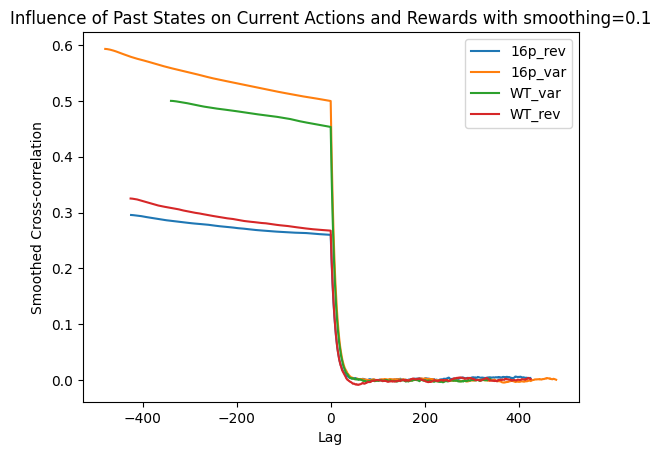

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# How current States influence future Actions and Rewards
# How past States influence current Actions and Rewards
def seq_states(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    S = df['tone_freq'].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
    results = []
    for t in range(len(S)):
        if S[t] == '6kHz':
            res = 1 
        elif S[t] == '10kHz':
            res = -1 
        results.append(res)
    return results

def seq_for_Actions_and_Rewards(link, c=1/2):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    rule = df['rule'].reset_index(drop=True)
    A = df['response'].reset_index(drop=True)
    R = df['rew_t'].reset_index(drop=True)
    results = []
    for t in range(len(A)):
        if A[t] == 'L' and R[t] == 1:
            res = 2 * c + c*rule[t]*(-4)
        elif A[t] == 'L' and R[t] == 0:
            res = 1 * c + c*rule[t]*(-2)
        elif A[t] == 'R' and R[t] == 0:
            res = -1 * c + c*rule[t]*(2)
        elif A[t] == 'R' and R[t] == 1:
            res = -2 * c + c*rule[t]*(4)
        else:
            res=0
        results.append(res)
    return results

def exponential_smoothing(data, alpha):
    smoothed = [data[0]]
    for i in range(1, len(data)):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(smoothed_value)
    return smoothed

def cross_correlation(seq1, seq2, max_lag, alpha):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            seq1_lagged = np.pad(seq1, (lag, 0), 'constant')[:len(seq1)]
            seq2_lagged = seq2[:len(seq1) - lag]
        elif lag < 0:
            seq1_lagged = seq1[:len(seq1) + lag]
            seq2_lagged = np.pad(seq2, (abs(lag), 0), 'constant')[:len(seq2)]
        else:
            seq1_lagged = seq1
            seq2_lagged = seq2

        correlation = np.correlate(seq1_lagged, seq2_lagged)[0] / (len(seq1_lagged) - abs(lag))
        correlations.append(correlation)
    
    smoothed_correlations = exponential_smoothing(correlations, alpha)
    
    return smoothed_correlations

df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')


links_16p_rev = df['link_16p_rev'].dropna().tolist()
links_16p_var = df['link_16p_var'].dropna().tolist()
links_WT_rev = df['link_WT_rev'].dropna().tolist()
links_WT_var = df['link_WT_var'].dropna().tolist()

def max_lag_per_mouseType(links):
    lengths = []
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        R = df['rew_t'].reset_index(drop=True)
        lengths.append(len(R))
    max_lag = int(0.2 * min(lengths))
    return max_lag

lag_16p_rev = max_lag_per_mouseType(links_16p_rev)
lag_16p_var = max_lag_per_mouseType(links_16p_var)
lag_WT_rev = max_lag_per_mouseType(links_WT_rev)
lag_WT_var = max_lag_per_mouseType(links_WT_var)

def compute_mean_correlations(links, max_lag, alpha):
    sum_correlations = np.zeros(2 * max_lag + 1)
    count = len(links)
    
    for link in links:
        seq1 = seq_for_Actions_and_Rewards(link, c=1/2)
        seq2 = seq_states(link)
        correlations = cross_correlation(seq1, seq2, max_lag, alpha)
        sum_correlations += correlations

    mean_correlations = sum_correlations / count
    return mean_correlations
alpha = 0.1
mean_correlations_16p_rev = compute_mean_correlations(links_16p_rev, lag_16p_rev,alpha)
mean_correlations_16p_var = compute_mean_correlations(links_16p_var, lag_16p_var, alpha)
mean_correlations_WT_var = compute_mean_correlations(links_WT_var, lag_WT_var, alpha)
mean_correlations_WT_rev = compute_mean_correlations(links_WT_rev, lag_WT_rev, alpha)

# Plot
lags_16p_rev = list(range(-lag_16p_rev, lag_16p_rev + 1))
lags_16p_var = list(range(-lag_16p_var, lag_16p_var + 1))
lags_WT_var = list(range(-lag_WT_var, lag_WT_var + 1))
lags_WT_rev = list(range(-lag_WT_rev, lag_WT_rev + 1))

plt.plot(lags_16p_rev, mean_correlations_16p_rev, label='16p_rev')
plt.plot(lags_16p_var, mean_correlations_16p_var, label='16p_var')
plt.plot(lags_WT_var, mean_correlations_WT_var, label='WT_var')
plt.plot(lags_WT_rev, mean_correlations_WT_rev, label='WT_rev')
plt.xlabel('Lag')
plt.ylabel('Smoothed Cross-correlation')
plt.title(f'Influence of Past States on Current Actions and Rewards with smoothing={alpha}')
plt.legend()
plt.show()


<center>  A/SR Correlation  <center>

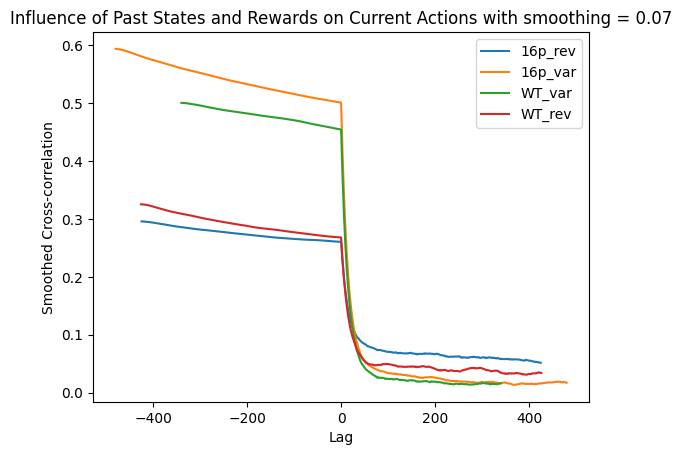

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#How Current Actions are influenced by Past Rewards and States
# How Future Actions are influenced by Current Rewards and States
def seq_actions(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    A = df['response'].reset_index(drop=True)
    rule = df['rule'].reset_index(drop=True)
    results = []
    for t in range(len(A)):
        if A[t] == 'L':
            res = 1 + rule[t] * (-2)
        elif A[t] == 'R':
            res = -1 + rule[t] * (2)
        else:
            res = 0
        results.append(res)
    return results

def seq_for_States_and_Rewards(link, c=1/2):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    S = df['tone_freq'].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
    R = df['rew_t'].reset_index(drop=True)
    results = []
    for t in range(len(S)):
        if S[t] == '6kHz' and R[t] == 1:
            res = 2 * c
        elif S[t] == '6kHz' and R[t] == 0:
            res = 1 * c
        elif S[t] == '10kHz' and R[t] == 0:
            res = -1 * c
        elif S[t] == '10kHz' and R[t] == 1:
            res = -2 * c
        results.append(res)
    return results

def exponential_smoothing(data, alpha):
    smoothed = [data[0]]
    for i in range(1, len(data)):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(smoothed_value)
    return smoothed

def cross_correlation(seq1, seq2, max_lag, alpha):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            seq1_lagged = np.pad(seq1, (lag, 0), 'constant')[:len(seq1)]
            seq2_lagged = seq2[:len(seq1) - lag]
        elif lag < 0:
            seq1_lagged = seq1[:len(seq1) + lag]
            seq2_lagged = np.pad(seq2, (abs(lag), 0), 'constant')[:len(seq2)]
        else:
            seq1_lagged = seq1
            seq2_lagged = seq2

        correlation = np.correlate(seq1_lagged, seq2_lagged)[0] / (len(seq1_lagged) - abs(lag))
        correlations.append(correlation)
    
    smoothed_correlations = exponential_smoothing(correlations, alpha)
    
    return smoothed_correlations

df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')


# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].dropna().tolist()
links_16p_var = df['link_16p_var'].dropna().tolist()
links_WT_rev = df['link_WT_rev'].dropna().tolist()
links_WT_var = df['link_WT_var'].dropna().tolist()

def max_lag_per_mouseType(links):
    lengths = []
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        R = df['rew_t'].reset_index(drop=True)
        lengths.append(len(R))
    max_lag = int(0.2 * min(lengths))
    return max_lag

lag_16p_rev = max_lag_per_mouseType(links_16p_rev)
lag_16p_var = max_lag_per_mouseType(links_16p_var)
lag_WT_rev = max_lag_per_mouseType(links_WT_rev)
lag_WT_var = max_lag_per_mouseType(links_WT_var)

def compute_mean_correlations(links, max_lag, alpha):
    sum_correlations = np.zeros(2 * max_lag + 1)
    count = len(links)
    
    for link in links:
        seq1 = seq_actions(link)
        seq2 = seq_for_States_and_Rewards(link, c=1/2)
        correlations = cross_correlation(seq1, seq2, max_lag, alpha)
        sum_correlations += correlations

    mean_correlations = sum_correlations / count
    return mean_correlations
alpha = 0.07
mean_correlations_16p_rev = compute_mean_correlations(links_16p_rev, lag_16p_rev, alpha)
mean_correlations_16p_var = compute_mean_correlations(links_16p_var, lag_16p_var, alpha)
mean_correlations_WT_var = compute_mean_correlations(links_WT_var, lag_WT_var, alpha)
mean_correlations_WT_rev = compute_mean_correlations(links_WT_rev, lag_WT_rev, alpha)

# Plot
lags_16p_rev = list(range(-lag_16p_rev, lag_16p_rev + 1))
lags_16p_var = list(range(-lag_16p_var, lag_16p_var + 1))
lags_WT_var = list(range(-lag_WT_var, lag_WT_var + 1))
lags_WT_rev = list(range(-lag_WT_rev, lag_WT_rev + 1))


plt.plot(lags_16p_rev, mean_correlations_16p_rev, label='16p_rev')
plt.plot(lags_16p_var, mean_correlations_16p_var, label='16p_var')
plt.plot(lags_WT_var, mean_correlations_WT_var, label='WT_var')
plt.plot(lags_WT_rev, mean_correlations_WT_rev, label='WT_rev')
plt.xlabel('Lag')
plt.ylabel('Smoothed Cross-correlation')
plt.title(f'Influence of Past States and Rewards on Current Actions with smoothing = {alpha}')
plt.legend()
plt.show()


<center> SA/R Correlation<center>

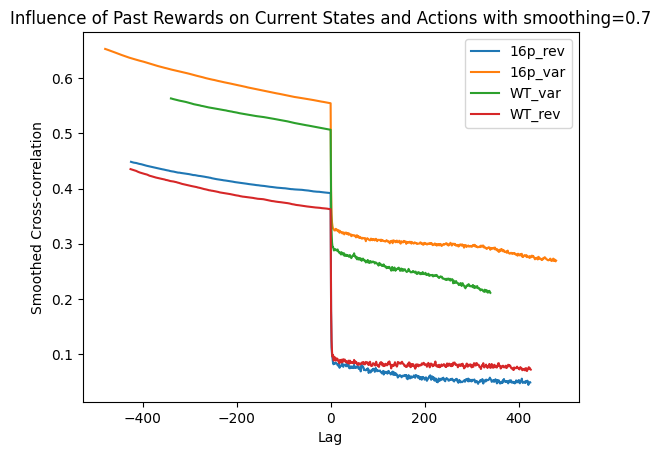

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# How Current Rewards affect future States and Actions
# How Past Rewards affect current States and Actions
def seq_Actions_and_States(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    A = df['response'].reset_index(drop=True)
    S = df['tone_freq'].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
    rule = df['rule'].reset_index(drop=True)
    results = []
    for t in range(len(A)):
        if ((A[t] == 'L') and (S[t]=='6kHz')) or ((A[t] == 'R') and (S[t]=='10kHz')):
            res = 1 +  rule[t] * (-2)
        elif ((A[t] == 'R') and (S[t]=='6kHz')) or ((A[t] == 'L') and (S[t]=='10kHz')):
            res = -1 + rule[t] * (2)
        else:
            res = 0
        results.append(res)
    return results

def seq_Rewards(link):
    df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
    R = df['rew_t'].reset_index(drop=True)
    results = []
    for t in range(len(R)):
        if R[t]:
            res=1
        else:
            res=0
        results.append(res)
    return results

def exponential_smoothing(data, alpha):
    smoothed = [data[0]]
    for i in range(1, len(data)):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(smoothed_value)
    return smoothed

def cross_correlation(seq1, seq2, max_lag, alpha):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            seq1_lagged = np.pad(seq1, (lag, 0), 'constant')[:len(seq1)]
            seq2_lagged = seq2[:len(seq1) - lag]
        elif lag < 0:
            seq1_lagged = seq1[:len(seq1) + lag]
            seq2_lagged = np.pad(seq2, (abs(lag), 0), 'constant')[:len(seq2)]
        else:
            seq1_lagged = seq1
            seq2_lagged = seq2

        correlation = np.correlate(seq1_lagged, seq2_lagged)[0] / (len(seq1_lagged) - abs(lag))
        correlations.append(correlation)
    
    smoothed_correlations = exponential_smoothing(correlations, alpha)
    
    return smoothed_correlations

df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')


# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].dropna().tolist()
links_16p_var = df['link_16p_var'].dropna().tolist()
links_WT_rev = df['link_WT_rev'].dropna().tolist()
links_WT_var = df['link_WT_var'].dropna().tolist()

def max_lag_per_mouseType(links):
    lengths = []
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        R = df['rew_t'].reset_index(drop=True)
        lengths.append(len(R))
    max_lag = int(0.2 * min(lengths))
    return max_lag

lag_16p_rev = max_lag_per_mouseType(links_16p_rev)
lag_16p_var = max_lag_per_mouseType(links_16p_var)
lag_WT_rev = max_lag_per_mouseType(links_WT_rev)
lag_WT_var = max_lag_per_mouseType(links_WT_var)

def compute_mean_correlations(links, max_lag, alpha):
    sum_correlations = np.zeros(2 * max_lag + 1)
    count = len(links)
    
    for link in links:
        seq1 = seq_Actions_and_States(link)
        seq2 = seq_Rewards(link)
        correlations = cross_correlation(seq1, seq2, max_lag, alpha)
        sum_correlations += correlations

    mean_correlations = sum_correlations / count
    return mean_correlations
alpha = 0.7
mean_correlations_16p_rev = compute_mean_correlations(links_16p_rev, lag_16p_rev, alpha)
mean_correlations_16p_var = compute_mean_correlations(links_16p_var, lag_16p_var, alpha)
mean_correlations_WT_var = compute_mean_correlations(links_WT_var, lag_WT_var, alpha)
mean_correlations_WT_rev = compute_mean_correlations(links_WT_rev, lag_WT_rev, alpha)

# Plot
lags_16p_rev = list(range(-lag_16p_rev, lag_16p_rev + 1))
lags_16p_var = list(range(-lag_16p_var, lag_16p_var + 1))
lags_WT_var = list(range(-lag_WT_var, lag_WT_var + 1))
lags_WT_rev = list(range(-lag_WT_rev, lag_WT_rev + 1))


plt.plot(lags_16p_rev, mean_correlations_16p_rev, label='16p_rev')
plt.plot(lags_16p_var, mean_correlations_16p_var, label='16p_var')
plt.plot(lags_WT_var, mean_correlations_WT_var, label='WT_var')
plt.plot(lags_WT_rev, mean_correlations_WT_rev, label='WT_rev')
plt.xlabel('Lag')
plt.ylabel('Smoothed Cross-correlation')
plt.title(f'Influence of Past Rewards on Current States and Actions with smoothing={alpha}')
plt.legend()
plt.show()